In [1]:
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("attribution_data.csv")

## 데이터

* Cookie: Randomly generated customer id enabling us to tie subsequent visits back to the same customer
* Timestamp: Date and time when the visit took place
* Interaction: Categorical variable indicating the type of interaction that took place
* Conversion: Boolean variable indicating whether a conversion took place
* Conversion Value: Value of the potential conversion event
* Channel: The marketing channel that brought the customer to our site

In [4]:
# 데이터는 시간 순으로 정렬됨
df.head(10)

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search
5,0000nACkD9nFkBBDECD3ki00E,2018-07-03T23:36:49Z,impression,0,0.0,Paid Search
6,0000nACkD9nFkBBDECD3ki00E,2018-07-10T22:24:41Z,impression,0,0.0,Paid Search
7,0000nACkD9nFkBBDECD3ki00E,2018-07-10T22:24:44Z,impression,0,0.0,Paid Search
8,0000nACkD9nFkBBDECD3ki00E,2018-07-11T21:21:46Z,impression,0,0.0,Paid Search
9,0000nACkD9nFkBBDECD3ki00E,2018-07-11T22:19:53Z,impression,0,0.0,Paid Search


In [5]:
df.interaction.drop_duplicates()

0     impression
22    conversion
Name: interaction, dtype: object

In [6]:
df.channel.drop_duplicates()

0          Instagram
1     Online Display
4        Paid Search
18          Facebook
24      Online Video
Name: channel, dtype: object

유저(쿠키)별로 보통 몇 개의 채널에 노출되었는지 확인

In [8]:
df_channels_per_cookie = df.groupby('cookie').channel.nunique().reset_index()
df_channels_per_cookie.head()

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,2
1,0000nACkD9nFkBBDECD3ki00E,1
2,0003EfE37E93D0BC03iBhBBhF,1
3,00073CFE3FoFCn70fBhB3kfon,1
4,00079hhBkDF3k3kDkiFi9EFAD,1


In [9]:
# 채널수 별 유저수(쿠키) 확인
df_channels_per_cookie.groupby('channel').count()

,cookie
channel,
1,183020
2,45964
3,9549
4,1473
5,102


## 도메인 지식을 활용한 Simple 채널 기여도 분석
- 기존에 알고 있는, 또는 잘 알려진 방법론을 사용
- 어떤 채널이 전환에 대한 기여도가 높은지

### Last Interaction Attribution Model
- 마지막으로 노출/클릭한 채널의 기여도를 100%로 기여했다고 간주

In [10]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'channel', 'conversion']]
print(len(df_last_interaction))
df_last_interaction.head(10)

240108


,cookie,channel,conversion
3,00000FkCnDfDDf0iC97iC703B,Online Display,0
9,0000nACkD9nFkBBDECD3ki00E,Paid Search,0
14,0003EfE37E93D0BC03iBhBBhF,Paid Search,0
15,00073CFE3FoFCn70fBhB3kfon,Instagram,0
16,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0
20,0007iiAiFh3ifoo9Ehn3ABB0F,Instagram,0
21,0007o0nfoh9o79DDfD7DAiEnE,Facebook,0
22,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1
23,00090n9EBBEkA000C7Cik999D,Facebook,1
28,000A9AfDohfiBAFB0FDf3kDEE,Online Video,0


In [11]:
# 전환이 된 경우 마지막으로 접한 채널이 무엇인지
df_last_interaction_conv = df_last_interaction.loc[df_last_interaction.conversion == 1,:]
print("전환수",len(df_last_interaction_conv))
df_last_interaction_conv.head()

전환수 17639


,cookie,channel,conversion
22,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1
23,00090n9EBBEkA000C7Cik999D,Facebook,1
83,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1
109,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,1
124,000kiDB3D0fCfDAohCDB3ohko,Facebook,1


In [12]:
last_interaction_attrib = (
    df_last_interaction_conv
    .groupby('channel')['cookie']
    .count()
    .reset_index()
    .rename(columns={"cookie": "attribution"})
)
last_interaction_attrib

,channel,attribution
0,Facebook,5301
1,Instagram,2244
2,Online Display,2139
3,Online Video,3408
4,Paid Search,4547


### First Interaction Attribution Model
- 고객이 상호작용한 첫 번째 채널이 전환 가치에 100% 기여했다고 간주

In [14]:
# 유저가 처음으로 접한 채널
df_first_interaction = df.drop_duplicates('cookie', keep='first')[['cookie', 'channel', 'conversion']]
print(len(df_first_interaction))
df_first_interaction.head(10)

240108


,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,Instagram,0
4,0000nACkD9nFkBBDECD3ki00E,Paid Search,0
10,0003EfE37E93D0BC03iBhBBhF,Paid Search,0
15,00073CFE3FoFCn70fBhB3kfon,Instagram,0
16,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0
17,0007iiAiFh3ifoo9Ehn3ABB0F,Instagram,0
21,0007o0nfoh9o79DDfD7DAiEnE,Facebook,0
22,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1
23,00090n9EBBEkA000C7Cik999D,Facebook,1
24,000A9AfDohfiBAFB0FDf3kDEE,Online Video,0


In [15]:
# 전환이 된 쿠키 아이디가 모여있는 데이터
print(len(df_last_interaction_conv))

17639


In [16]:
# 전환 데이터와 merge
df_first_interaction_conv = (
    df_first_interaction[['cookie', 'channel']]
      .merge(df_last_interaction_conv[['cookie', 'conversion']], 
             on='cookie')
)

print(len(df_first_interaction_conv))

17639


In [17]:
first_interaction_attrib = (
    df_first_interaction_conv
    .groupby('channel')['cookie']
    .count()
    .reset_index()
    .rename(columns={"cookie": "attribution"})
)
first_interaction_attrib

,channel,attribution
0,Facebook,5177
1,Instagram,2329
2,Online Display,2160
3,Online Video,3216
4,Paid Search,4757


### Linear Interaction Attribution Model
- 전환 경로에서 발생한 모든 채널의 기여도가 균등하다고 가정


먼저 유저 아이디 별로 중복되는 채널은 제거

In [18]:
# 각 유저 별로 채널 별 데이터를 각 1개씩 남김
df_uniq_chl = df.drop_duplicates(['cookie', 'channel'], keep='last')[['cookie', 'channel']]
print(len(df_uniq_chl))
df_uniq_chl.head()

309997


,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,Instagram
3,00000FkCnDfDDf0iC97iC703B,Online Display
9,0000nACkD9nFkBBDECD3ki00E,Paid Search
14,0003EfE37E93D0BC03iBhBBhF,Paid Search
15,00073CFE3FoFCn70fBhB3kfon,Instagram


유저 아이디 별 채널 수를 구한다 (기여도를 균등하게 나눌 때 이 값을 사용)

In [19]:
df_uniq_chl_cnt = (
    df_uniq_chl
    .groupby('cookie')
    .count()
    .rename(columns = {"channel": "channel_cnt"})
    .reset_index()
)
df_uniq_chl_cnt.head()

,cookie,channel_cnt
0,00000FkCnDfDDf0iC97iC703B,2
1,0000nACkD9nFkBBDECD3ki00E,1
2,0003EfE37E93D0BC03iBhBBhF,1
3,00073CFE3FoFCn70fBhB3kfon,1
4,00079hhBkDF3k3kDkiFi9EFAD,1


In [20]:
df_uniq_chl_total = df_uniq_chl.merge(df_uniq_chl_cnt, on = 'cookie')
df_uniq_chl_total.head()

,cookie,channel,channel_cnt
0,00000FkCnDfDDf0iC97iC703B,Instagram,2
1,00000FkCnDfDDf0iC97iC703B,Online Display,2
2,0000nACkD9nFkBBDECD3ki00E,Paid Search,1
3,0003EfE37E93D0BC03iBhBBhF,Paid Search,1
4,00073CFE3FoFCn70fBhB3kfon,Instagram,1


In [21]:
# 전환 데이터와 merge
df_linear_interaction_conv = (
    df_uniq_chl_total
      .merge(df_last_interaction_conv[['cookie', 'conversion']], 
             on='cookie')
)

In [22]:
len(df_linear_interaction_conv)

24716

In [23]:
#전환을 채널수로 나누기
df_linear_interaction_conv['linear_attr'] = (
    df_linear_interaction_conv.conversion
            .divide(
                df_linear_interaction_conv.channel_cnt
            ) 
)

In [24]:
df_linear_interaction_conv.head()

,cookie,channel,channel_cnt,conversion,linear_attr
0,0007oEBhnoF97AoEE3BCkFnhB,Paid Search,1,1,1.0
1,00090n9EBBEkA000C7Cik999D,Facebook,1,1,1.0
2,000h3n9nC0hFhE3CCnkkAof7n,Facebook,1,1,1.0
3,000hCBnCB7oi7ADAEnEBCnBEE,Instagram,2,1,0.5
4,000hCBnCB7oi7ADAEnEBCnBEE,Online Video,2,1,0.5


In [25]:
# 채널별 기여도의 합

linear_interaction_attrib = (
    df_linear_interaction_conv
    .groupby('channel')['linear_attr']
    .sum()
    .reset_index()
    .rename(columns={"linear_attr": "attribution"})
)
linear_interaction_attrib

,channel,attribution
0,Facebook,4947.600000
1,Instagram,2627.100000
2,Online Display,2143.600000
3,Online Video,3192.183333
4,Paid Search,4728.516667


### 3가지 기여도 분석방법 비교

In [26]:
last_interaction_attrib["method"] = "last"
first_interaction_attrib["method"] = "first"
linear_interaction_attrib["method"] = "linear"

In [27]:
last_interaction_attrib

,channel,attribution,method
0,Facebook,5301,last
1,Instagram,2244,last
2,Online Display,2139,last
3,Online Video,3408,last
4,Paid Search,4547,last


In [28]:
linear_interaction_attrib

,channel,attribution,method
0,Facebook,4947.600000,linear
1,Instagram,2627.100000,linear
2,Online Display,2143.600000,linear
3,Online Video,3192.183333,linear
4,Paid Search,4728.516667,linear


In [29]:
total_data = (
    last_interaction_attrib
    .append(first_interaction_attrib, ignore_index=True)
    .append(linear_interaction_attrib, ignore_index=True)
)

total_data

,channel,attribution,method
0,Facebook,5301.000000,last
1,Instagram,2244.000000,last
2,Online Display,2139.000000,last
3,Online Video,3408.000000,last
4,Paid Search,4547.000000,last
5,Facebook,5177.000000,first
6,Instagram,2329.000000,first
7,Online Display,2160.000000,first
8,Online Video,3216.000000,first
9,Paid Search,4757.000000,first


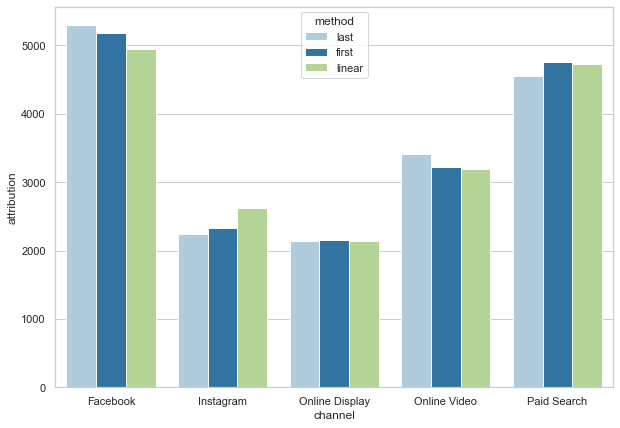

In [30]:
sns.set_theme(style="whitegrid", palette="Paired") # 테마를 설정한다
g = sns.barplot(x=total_data.channel, y=total_data.attribution, hue = total_data.method)
g.figure.set_size_inches(10, 7)

# Markov Chain 을 통한 채널 기여도 분석

- 유저가 여러 경로를 통해 제품을 접하고 구매를 할 때 통계적인 방법으로 기여도 분배# 

## 각 채널로 움직이는 전이 확률 (Transition Probability) 구하기

In [31]:
# 유저 별로 접한 채널을 모두 list로 변환
df_paths = (
    df.groupby('cookie')['channel']
      .aggregate(
          lambda x: x.unique().tolist()
      )
      .reset_index()  
)

In [32]:
df_paths.head(10)

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]
5,0007iiAiFh3ifoo9Ehn3ABB0F,"[Instagram, Facebook]"
6,0007o0nfoh9o79DDfD7DAiEnE,[Facebook]
7,0007oEBhnoF97AoEE3BCkFnhB,[Paid Search]
8,00090n9EBBEkA000C7Cik999D,[Facebook]
9,000A9AfDohfiBAFB0FDf3kDEE,[Online Video]


In [33]:
# 유저 별 전환 여부 : 각 유저 별 마지막 row 만 남기고 삭제
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head(10)

,cookie,conversion
3,00000FkCnDfDDf0iC97iC703B,0
9,0000nACkD9nFkBBDECD3ki00E,0
14,0003EfE37E93D0BC03iBhBBhF,0
15,00073CFE3FoFCn70fBhB3kfon,0
16,00079hhBkDF3k3kDkiFi9EFAD,0
20,0007iiAiFh3ifoo9Ehn3ABB0F,0
21,0007o0nfoh9o79DDfD7DAiEnE,0
22,0007oEBhnoF97AoEE3BCkFnhB,1
23,00090n9EBBEkA000C7Cik999D,1
28,000A9AfDohfiBAFB0FDf3kDEE,0


In [34]:
# 기 만든 path 데이터에 conversion 전환 여부를 합침
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

In [35]:
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


Markov Chain 의 State 종류
* Start: 첫 시작 
* Instagram: 인스타그램 광고
* Paid Search: 유료 검색 광고
* Facebook: 페이스북 광고
* Online Video: 비디오형 광고
* Online Display: 배너 노출 광고
* Conversion: 전환 성공 (구매 완료)
* Null: 전환 실패 (구매 없이 나감)
 

In [36]:
# 시작 state 추가
# 최종 state 추가
# 전환이 안되었다면 Null, 전환되었다면 Conversion State 를 캠페인 Path 뒤에 추가 
df_paths['paths'] = (
    df_paths
      .apply( 
          lambda x: ['Start'] + x.channel + ['Null'] 
            if x.conversion == 0 
            else ['Start'] + x.channel + ['Conversion'], 
          axis=1
      )
)

In [37]:
df_paths.head(10)

,cookie,channel,conversion,paths
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Null]"
5,0007iiAiFh3ifoo9Ehn3ABB0F,"[Instagram, Facebook]",0,"[Start, Instagram, Facebook, Null]"
6,0007o0nfoh9o79DDfD7DAiEnE,[Facebook],0,"[Start, Facebook, Null]"
7,0007oEBhnoF97AoEE3BCkFnhB,[Paid Search],1,"[Start, Paid Search, Conversion]"
8,00090n9EBBEkA000C7Cik999D,[Facebook],1,"[Start, Facebook, Conversion]"
9,000A9AfDohfiBAFB0FDf3kDEE,[Online Video],0,"[Start, Online Video, Null]"


In [38]:
# 총 쿠키수와 그 중 전환된 쿠키수 계산
cookie_count = len(df_paths)
conversion_count = len(df_paths.loc[df_paths.conversion == 1, :])
print(cookie_count)
print(conversion_count)

240108
17639


In [39]:
# 전체 전환율 약 7.3%
base_conversion_rate = conversion_count / cookie_count
print(base_conversion_rate)

0.07346277508454528


In [40]:
# transition 확률을 구하기 위한 데이터
list_of_paths = df_paths['paths']

In [41]:
# Unique 한 사건
list_of_unique_channels = set(x for element in list_of_paths for x in element)
list_of_unique_channels

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

In [42]:
list_of_paths[:5]

0    [Start, Instagram, Online Display, Null]
1                  [Start, Paid Search, Null]
2                  [Start, Paid Search, Null]
3                    [Start, Instagram, Null]
4                  [Start, Paid Search, Null]
Name: paths, dtype: object

Markov Chain 은 현재와 그 다음 상태 사이의 전이확률만 필요
- 더 과거의 상태는 알 필요 없음

In [43]:
# 전이 가능성이 있는 모든 상태를 count 하기 위해서 0으로 초기화
transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

In [44]:
transition_states

{'Instagram>Instagram': 0,
 'Instagram>Online Display': 0,
 'Instagram>Facebook': 0,
 'Instagram>Start': 0,
 'Instagram>Paid Search': 0,
 'Instagram>Conversion': 0,
 'Instagram>Online Video': 0,
 'Instagram>Null': 0,
 'Online Display>Instagram': 0,
 'Online Display>Online Display': 0,
 'Online Display>Facebook': 0,
 'Online Display>Start': 0,
 'Online Display>Paid Search': 0,
 'Online Display>Conversion': 0,
 'Online Display>Online Video': 0,
 'Online Display>Null': 0,
 'Facebook>Instagram': 0,
 'Facebook>Online Display': 0,
 'Facebook>Facebook': 0,
 'Facebook>Start': 0,
 'Facebook>Paid Search': 0,
 'Facebook>Conversion': 0,
 'Facebook>Online Video': 0,
 'Facebook>Null': 0,
 'Start>Instagram': 0,
 'Start>Online Display': 0,
 'Start>Facebook': 0,
 'Start>Start': 0,
 'Start>Paid Search': 0,
 'Start>Conversion': 0,
 'Start>Online Video': 0,
 'Start>Null': 0,
 'Paid Search>Instagram': 0,
 'Paid Search>Online Display': 0,
 'Paid Search>Facebook': 0,
 'Paid Search>Start': 0,
 'Paid Search>Pa

In [45]:
# 각 상태에서 다음 상태로 간 것이 몇 번인지
for possible_state in list_of_unique_channels: 
    if possible_state not in ['Conversion', 'Null']: # 전환/ 전환 안됨 상태를 제외
        for user_path in list_of_paths:
            if possible_state in user_path:
                indices = [i for i, s in enumerate(user_path) if possible_state in s] 
                for col in indices:
                    key = user_path[col] + '>' + user_path[col + 1]
                    transition_states[key] += 1 

In [46]:
transition_states

{'Instagram>Instagram': 0,
 'Instagram>Online Display': 1164,
 'Instagram>Facebook': 10822,
 'Instagram>Start': 0,
 'Instagram>Paid Search': 2266,
 'Instagram>Conversion': 2868,
 'Instagram>Online Video': 1193,
 'Instagram>Null': 31153,
 'Online Display>Instagram': 1251,
 'Online Display>Online Display': 0,
 'Online Display>Facebook': 2300,
 'Online Display>Start': 0,
 'Online Display>Paid Search': 3936,
 'Online Display>Conversion': 2144,
 'Online Display>Online Video': 737,
 'Online Display>Null': 32236,
 'Facebook>Instagram': 15252,
 'Facebook>Online Display': 2146,
 'Facebook>Facebook': 0,
 'Facebook>Start': 0,
 'Facebook>Paid Search': 4464,
 'Facebook>Conversion': 4690,
 'Facebook>Online Video': 2254,
 'Facebook>Null': 59319,
 'Start>Instagram': 28618,
 'Start>Online Display': 34250,
 'Start>Facebook': 66848,
 'Start>Start': 0,
 'Start>Paid Search': 76210,
 'Start>Conversion': 0,
 'Start>Online Video': 34182,
 'Start>Null': 0,
 'Paid Search>Instagram': 3038,
 'Paid Search>Online D

In [47]:
# 함수로 표현
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states

trans_states = transition_states(list_of_paths)

In [48]:
trans_states.keys()

dict_keys(['Instagram>Instagram', 'Instagram>Online Display', 'Instagram>Facebook', 'Instagram>Start', 'Instagram>Paid Search', 'Instagram>Conversion', 'Instagram>Online Video', 'Instagram>Null', 'Online Display>Instagram', 'Online Display>Online Display', 'Online Display>Facebook', 'Online Display>Start', 'Online Display>Paid Search', 'Online Display>Conversion', 'Online Display>Online Video', 'Online Display>Null', 'Facebook>Instagram', 'Facebook>Online Display', 'Facebook>Facebook', 'Facebook>Start', 'Facebook>Paid Search', 'Facebook>Conversion', 'Facebook>Online Video', 'Facebook>Null', 'Start>Instagram', 'Start>Online Display', 'Start>Facebook', 'Start>Start', 'Start>Paid Search', 'Start>Conversion', 'Start>Online Video', 'Start>Null', 'Paid Search>Instagram', 'Paid Search>Online Display', 'Paid Search>Facebook', 'Paid Search>Start', 'Paid Search>Paid Search', 'Paid Search>Conversion', 'Paid Search>Online Video', 'Paid Search>Null', 'Conversion>Instagram', 'Conversion>Online Displ

확률 정의
* transition probability 로 정의하려면, 각 채널에서 다음 채널로 가는 수를 다 더해서 나눠줌

In [49]:
trans_prob = defaultdict(dict)

In [50]:
trans_prob

defaultdict(dict, {})

In [51]:
trans_states

{'Instagram>Instagram': 0,
 'Instagram>Online Display': 1164,
 'Instagram>Facebook': 10822,
 'Instagram>Start': 0,
 'Instagram>Paid Search': 2266,
 'Instagram>Conversion': 2868,
 'Instagram>Online Video': 1193,
 'Instagram>Null': 31153,
 'Online Display>Instagram': 1251,
 'Online Display>Online Display': 0,
 'Online Display>Facebook': 2300,
 'Online Display>Start': 0,
 'Online Display>Paid Search': 3936,
 'Online Display>Conversion': 2144,
 'Online Display>Online Video': 737,
 'Online Display>Null': 32236,
 'Facebook>Instagram': 15252,
 'Facebook>Online Display': 2146,
 'Facebook>Facebook': 0,
 'Facebook>Start': 0,
 'Facebook>Paid Search': 4464,
 'Facebook>Conversion': 4690,
 'Facebook>Online Video': 2254,
 'Facebook>Null': 59319,
 'Start>Instagram': 28618,
 'Start>Online Display': 34250,
 'Start>Facebook': 66848,
 'Start>Start': 0,
 'Start>Paid Search': 76210,
 'Start>Conversion': 0,
 'Start>Online Video': 34182,
 'Start>Null': 0,
 'Paid Search>Instagram': 3038,
 'Paid Search>Online D

In [52]:
for state in list_of_unique_channels: 
    if state not in ['Conversion', 'Null']:
        next_states_from_state = [s for s in trans_states if state + '>' in s]
        counter = 0
        for next_state in next_states_from_state:
            if trans_states[next_state] > 0:
                counter += trans_states[next_state]
        for next_state in next_states_from_state:
            if trans_states[next_state] > 0:
                state_prob = float((trans_states[next_state])) / float(counter)
                trans_prob[next_state] = state_prob

In [53]:
trans_prob

defaultdict(dict,
            {'Instagram>Online Display': 0.023531314438199977,
             'Instagram>Facebook': 0.2187765333764606,
             'Instagram>Paid Search': 0.04580924271216593,
             'Instagram>Conversion': 0.057979218048760765,
             'Instagram>Online Video': 0.024117575708567502,
             'Instagram>Null': 0.6297861157158452,
             'Online Display>Instagram': 0.02936344005257722,
             'Online Display>Facebook': 0.053985541263731104,
             'Online Display>Paid Search': 0.09238569148436766,
             'Online Display>Conversion': 0.05032391324758239,
             'Online Display>Online Video': 0.017298845178856444,
             'Online Display>Null': 0.7566425687728852,
             'Facebook>Instagram': 0.1730723404255319,
             'Facebook>Online Display': 0.02435177304964539,
             'Facebook>Paid Search': 0.05065531914893617,
             'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Online

In [54]:
# 함수로 정의
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels: 
        if state not in ['Conversion', 'Null']:
            next_states_from_state = [s for s in trans_dict if state + '>' in s]
            counter = 0
            for next_state in next_states_from_state:
                state 
                if trans_dict[next_state] > 0:
                    counter += trans_dict[next_state]
            for next_state in next_states_from_state:
                if trans_dict[next_state] > 0:
                    state_prob = float((trans_dict[next_state])) / float(counter)
                    trans_prob[next_state] = state_prob
    return trans_prob


trans_prob = transition_prob(trans_states)

In [55]:
trans_prob

defaultdict(dict,
            {'Instagram>Online Display': 0.023531314438199977,
             'Instagram>Facebook': 0.2187765333764606,
             'Instagram>Paid Search': 0.04580924271216593,
             'Instagram>Conversion': 0.057979218048760765,
             'Instagram>Online Video': 0.024117575708567502,
             'Instagram>Null': 0.6297861157158452,
             'Online Display>Instagram': 0.02936344005257722,
             'Online Display>Facebook': 0.053985541263731104,
             'Online Display>Paid Search': 0.09238569148436766,
             'Online Display>Conversion': 0.05032391324758239,
             'Online Display>Online Video': 0.017298845178856444,
             'Online Display>Null': 0.7566425687728852,
             'Facebook>Instagram': 0.1730723404255319,
             'Facebook>Online Display': 0.02435177304964539,
             'Facebook>Paid Search': 0.05065531914893617,
             'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Online

## 전이확률행렬(Transition Probability Matrix)로 만들기## 

In [56]:
trans_matrix = pd.DataFrame()

In [57]:
channel = "Instagram"
trans_matrix[channel] = 0.00
trans_matrix

,Instagram


In [58]:
trans_matrix.loc["Instagram"] = 0.00
trans_matrix

,Instagram
Instagram,0.0


In [59]:
# Dataframe 의 index와 column에 채널을 추가
# Conversion과 Null 인 경우 그 다음 State 로 갈 수 없기 때문에, 각각 1을 부여
for channel in list_of_unique_channels:
    trans_matrix[channel] = 0.00
    trans_matrix.loc[channel] = 0.00

    # 자기 자신으로 가는 확률을 부여
    trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0


In [60]:
trans_matrix

,Instagram,Online Display,Facebook,Start,Paid Search,Conversion,Online Video,Null
Instagram,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Online Display,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Facebook,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Start,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Paid Search,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Conversion,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Online Video,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:
for key, value in trans_prob.items():
    origin, destination = key.split('>') # From, To 
    trans_matrix.at[origin, destination] = value

In [62]:
trans_matrix

,Instagram,Online Display,Facebook,Start,Paid Search,Conversion,Online Video,Null
Instagram,0.000000,0.023531,0.218777,0.0,0.045809,0.057979,0.024118,0.629786
Online Display,0.029363,0.000000,0.053986,0.0,0.092386,0.050324,0.017299,0.756643
Facebook,0.173072,0.024352,0.000000,0.0,0.050655,0.053220,0.025577,0.673123
Start,0.119188,0.142644,0.278408,0.0,0.317399,0.000000,0.142361,0.000000
Paid Search,0.034196,0.048053,0.064442,0.0,0.000000,0.053309,0.029221,0.770779
Conversion,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
Online Video,0.031908,0.018920,0.059323,0.0,0.047947,0.078146,0.000000,0.763757
Null,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000


In [63]:
# 함수 정리
def transition_matrix(list_of_paths, transition_probabilities):

    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [64]:
trans_matrix

,Instagram,Online Display,Facebook,Start,Paid Search,Conversion,Online Video,Null
Instagram,0.000000,0.023531,0.218777,0.0,0.045809,0.057979,0.024118,0.629786
Online Display,0.029363,0.000000,0.053986,0.0,0.092386,0.050324,0.017299,0.756643
Facebook,0.173072,0.024352,0.000000,0.0,0.050655,0.053220,0.025577,0.673123
Start,0.119188,0.142644,0.278408,0.0,0.317399,0.000000,0.142361,0.000000
Paid Search,0.034196,0.048053,0.064442,0.0,0.000000,0.053309,0.029221,0.770779
Conversion,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
Online Video,0.031908,0.018920,0.059323,0.0,0.047947,0.078146,0.000000,0.763757
Null,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000


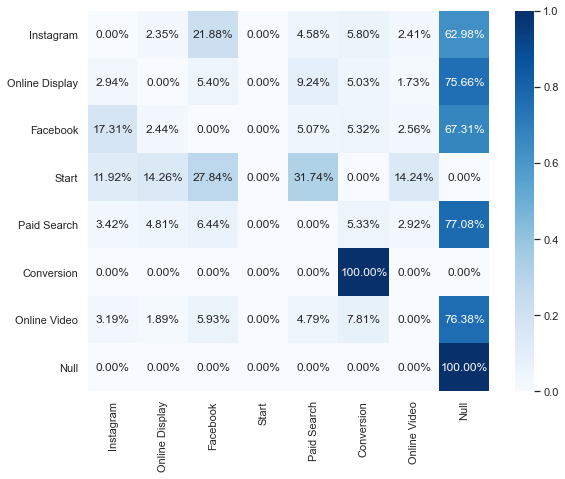

In [65]:
g = sns.heatmap(trans_matrix, annot=True, fmt='.2%', cmap="Blues")
g.figure.set_size_inches(9, 7)

# Absorbing Markov Chain 을 통한 채널 기여도 분석

## 각 채널의 Removal Effect

In [66]:
for channel in trans_matrix.columns:
  print(channel)

Instagram
Online Display
Facebook
Start
Paid Search
Conversion
Online Video
Null


In [67]:
trans_matrix

,Instagram,Online Display,Facebook,Start,Paid Search,Conversion,Online Video,Null
Instagram,0.000000,0.023531,0.218777,0.0,0.045809,0.057979,0.024118,0.629786
Online Display,0.029363,0.000000,0.053986,0.0,0.092386,0.050324,0.017299,0.756643
Facebook,0.173072,0.024352,0.000000,0.0,0.050655,0.053220,0.025577,0.673123
Start,0.119188,0.142644,0.278408,0.0,0.317399,0.000000,0.142361,0.000000
Paid Search,0.034196,0.048053,0.064442,0.0,0.000000,0.053309,0.029221,0.770779
Conversion,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
Online Video,0.031908,0.018920,0.059323,0.0,0.047947,0.078146,0.000000,0.763757
Null,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000


In [68]:
removal_effects_dict = {}
channels = [column for column in trans_matrix.columns if column not in ['Start', 'Null', 'Conversion']]

In [69]:
channels

['Instagram', 'Online Display', 'Facebook', 'Paid Search', 'Online Video']

예) Facebook 의 제거효과

In [70]:
channel = 'Facebook'
removal_df = trans_matrix.drop(channel, axis=1).drop(channel, axis=0)

In [71]:
# 전이 확률 : 행으로 다 더했을 때 1이 되어야 함
removal_df

,Instagram,Online Display,Start,Paid Search,Conversion,Online Video,Null
Instagram,0.000000,0.023531,0.0,0.045809,0.057979,0.024118,0.629786
Online Display,0.029363,0.000000,0.0,0.092386,0.050324,0.017299,0.756643
Start,0.119188,0.142644,0.0,0.317399,0.000000,0.142361,0.000000
Paid Search,0.034196,0.048053,0.0,0.000000,0.053309,0.029221,0.770779
Conversion,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
Online Video,0.031908,0.018920,0.0,0.047947,0.078146,0.000000,0.763757
Null,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000


In [72]:
removal_df.sum(axis=1)

Instagram         0.781223
Online Display    0.946014
Start             0.721592
Paid Search       0.935558
Conversion        1.000000
Online Video      0.940677
Null              1.000000
dtype: float64

In [73]:
removal_df.columns

Index(['Instagram', 'Online Display', 'Start', 'Paid Search', 'Conversion',
       'Online Video', 'Null'],
      dtype='object')

In [74]:
# Facebook 으로 가던 전이확률을 다 Null 로 가는 확률로 더해줌
for column in removal_df.columns:
    row_sum = np.sum(list(removal_df.loc[column]))

    null_pct = float(1) - row_sum
    print(column, row_sum, null_pct)
    if null_pct != 0:
        removal_df.loc[column]['Null'] = removal_df.loc[column]['Null'] + null_pct
    removal_df.loc['Null']['Null'] = 1.0

Instagram 0.7812234666235394 0.21877653337646064
Online Display 0.9460144587362689 0.05398554126373112
Start 0.7215919502890367 0.27840804971096333
Paid Search 0.935558307068888 0.06444169293111202
Conversion 1.0 0.0
Online Video 0.9406767247692984 0.05932327523070158
Null 1.0 0.0


In [75]:
removal_df.sum(axis=1)

Instagram         1.0
Online Display    1.0
Start             1.0
Paid Search       1.0
Conversion        1.0
Online Video      1.0
Null              1.0
dtype: float64

In [76]:
removal_df

,Instagram,Online Display,Start,Paid Search,Conversion,Online Video,Null
Instagram,0.000000,0.023531,0.0,0.045809,0.057979,0.024118,0.848563
Online Display,0.029363,0.000000,0.0,0.092386,0.050324,0.017299,0.810628
Start,0.119188,0.142644,0.0,0.317399,0.000000,0.142361,0.278408
Paid Search,0.034196,0.048053,0.0,0.000000,0.053309,0.029221,0.835221
Conversion,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.000000
Online Video,0.031908,0.018920,0.0,0.047947,0.078146,0.000000,0.823080
Null,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000


- Absorbing Markov Chain 공식
- 맨 처음에 Start 에서 시작해서 어떤 State 를 다 거치고 오더라도, 결과적으로 Conversion으로 가는 확률값 
- = Facebook 을 제거했을 때 Start에서 시작한 최종적인 전환율

In [77]:
# Abosorbing States : 변화하지 않는 States : Null or Conversion
# Transient States : 변화하는 States : 나머지 (Start,... Channel)

removal_to_conv = removal_df[
    ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)

removal_to_non_conv = removal_df.drop(
    ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

In [78]:
# Absorbing States : null, conversion 만 있는 dataframe 
removal_to_conv

,Null,Conversion
Instagram,0.848563,0.057979
Online Display,0.810628,0.050324
Start,0.278408,0.000000
Paid Search,0.835221,0.053309
Online Video,0.823080,0.078146


In [79]:
# Transient States : null, conversion 을 제거한 dataframe 
removal_to_non_conv

,Instagram,Online Display,Start,Paid Search,Online Video
Instagram,0.000000,0.023531,0.0,0.045809,0.024118
Online Display,0.029363,0.000000,0.0,0.092386,0.017299
Start,0.119188,0.142644,0.0,0.317399,0.142361
Paid Search,0.034196,0.048053,0.0,0.000000,0.029221
Online Video,0.031908,0.018920,0.0,0.047947,0.000000


In [80]:
np.asarray(removal_to_non_conv)

array([[0.        , 0.02353131, 0.        , 0.04580924, 0.02411758],
       [0.02936344, 0.        , 0.        , 0.09238569, 0.01729885],
       [0.11918803, 0.14264414, 0.        , 0.31739884, 0.14236094],
       [0.03419631, 0.04805268, 0.        , 0.        , 0.02922107],
       [0.03190762, 0.01891997, 0.        , 0.04794688, 0.        ]])

In [81]:
I = np.identity(len(removal_to_non_conv.columns))
print(I)

Q = np.asarray(removal_to_non_conv)
print(Q)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[0.         0.02353131 0.         0.04580924 0.02411758]
 [0.02936344 0.         0.         0.09238569 0.01729885]
 [0.11918803 0.14264414 0.         0.31739884 0.14236094]
 [0.03419631 0.04805268 0.         0.         0.02922107]
 [0.03190762 0.01891997 0.         0.04794688 0.        ]]


In [82]:
mat = I - Q
mat

array([[ 1.        , -0.02353131,  0.        , -0.04580924, -0.02411758],
       [-0.02936344,  1.        ,  0.        , -0.09238569, -0.01729885],
       [-0.11918803, -0.14264414,  1.        , -0.31739884, -0.14236094],
       [-0.03419631, -0.04805268,  0.        ,  1.        , -0.02922107],
       [-0.03190762, -0.01891997,  0.        , -0.04794688,  1.        ]])

In [83]:
# 역행렬
removal_inv_diff = np.linalg.inv(mat)
F = np.linalg.inv(I - Q)

In [84]:
removal_inv_diff

array([[1.00330901, 0.0264894 , 0.        , 0.0496598 , 0.02610673],
       [0.03346716, 1.0057718 , 0.        , 0.09545869, 0.02099524],
       [0.14097535, 0.16562845, 1.        , 0.34677051, 0.15875911],
       [0.03692335, 0.04988651, 0.        , 1.00779629, 0.03120237],
       [0.03441676, 0.02226629, 0.        , 0.05171129, 1.00272629]])

In [85]:
removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))

In [86]:
removal_dot_prod 

array([[0.93580842, 0.06419158],
       [0.9407157 , 0.0592843 ],
       [0.95259886, 0.04740114],
       [0.93918547, 0.06081453],
       [0.91576868, 0.08423132]])

In [87]:
removal_to_conv

,Null,Conversion
Instagram,0.848563,0.057979
Online Display,0.810628,0.050324
Start,0.278408,0.000000
Paid Search,0.835221,0.053309
Online Video,0.823080,0.078146


In [88]:
pd.DataFrame(removal_dot_prod, index=removal_to_conv.index, columns = removal_to_conv.columns)

# Start -> Conversion : 0.047401 4.7%

,Null,Conversion
Instagram,0.935808,0.064192
Online Display,0.940716,0.059284
Start,0.952599,0.047401
Paid Search,0.939185,0.060815
Online Video,0.915769,0.084231


In [89]:
# Facebook 제거 후 총 전환율
removal_cvr = pd.DataFrame(removal_dot_prod,
                            index=removal_to_conv.index)[[1]].loc['Start'].values[0]
removal_cvr

0.04740113808165116

In [90]:
# 원래의 전환율
base_conversion_rate

0.07346277508454528

In [91]:
# 전체 전환율 중 Facebook 을 제거한 전환율의 비중
removal_cvr / base_conversion_rate

0.6452402325817279

In [92]:
# 아 전환율의 35%가 사라짐 (하지만 모든 채널의 효과를 구해서 다시 비중을 조정해야 함)
removal_effect = 1 - removal_cvr / base_conversion_rate
removal_effect

0.3547597674182721

In [95]:
# 각 컬럼에 대한 제거효과 
# 함수 정리

def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = removal_df.loc[column]['Null'] + null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        # removal_effects_dict
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict

In [96]:
removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)
removal_effects_dict

{'Instagram': 0.21731366149038456,
 'Online Display': 0.15435482356041286,
 'Facebook': 0.3547597674182721,
 'Paid Search': 0.3311037560086154,
 'Online Video': 0.20691411655642178}

전체 전환수에 대한 각 채널의 기여도

In [97]:
# 전체 확률
re_sum = np.sum(list(removal_effects_dict.values()))
re_sum

1.2644461250341066

In [98]:
conversion_count

17639

In [101]:
# 앞에서 구한 확률을 전체 확률로 나누고, 총 전환수에 곱함
# 의미: 각 제거 효과로 구한 확률의 비중만큼 전환에 대한 기여도를 재조정
for k, v in removal_effects_dict.items():
    print(k," : " , (v / re_sum) * conversion_count)

Instagram  :  3031.521548555893
Online Display  :  2153.2469267590836
Facebook  :  4948.892177847523
Paid Search  :  4618.891257291356
Online Video  :  2886.4480895461456


In [102]:
# 함수 정리
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, conversion_count)

In [103]:
attributions

{'Instagram': 3031.521548555893,
 'Online Display': 2153.2469267590836,
 'Facebook': 4948.892177847523,
 'Paid Search': 4618.891257291356,
 'Online Video': 2886.4480895461456}

In [104]:
conversion_count

17639

In [105]:
sum(attributions.values())

17639.0

In [106]:
attribution_by_markov = pd.DataFrame({'channel': attributions.keys(), 'attribution': attributions.values()})
attribution_by_markov

,channel,attribution
0,Instagram,3031.521549
1,Online Display,2153.246927
2,Facebook,4948.892178
3,Paid Search,4618.891257
4,Online Video,2886.448090


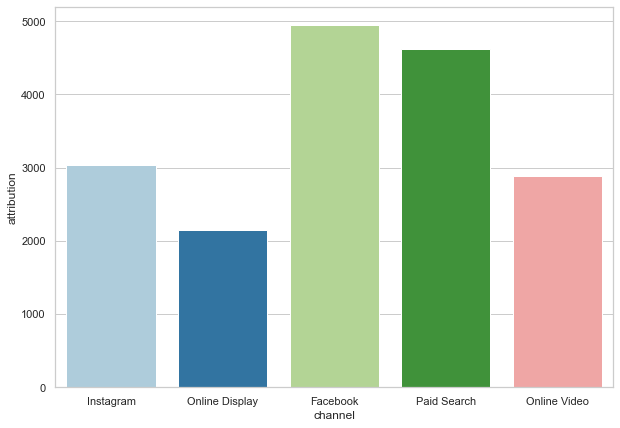

In [107]:
sns.set_theme(style="whitegrid", palette="Paired")
g = sns.barplot(x=attribution_by_markov.channel, y=attribution_by_markov.attribution, data = attribution_by_markov)
g.figure.set_size_inches(10, 7)

## Simple 기여도 모델과 Markov Chain 모델로 구한 기여도 비교

In [108]:
attribution_by_markov["method"] = "markov"

In [109]:
total_with_markov = total_data.append(attribution_by_markov, ignore_index = True)

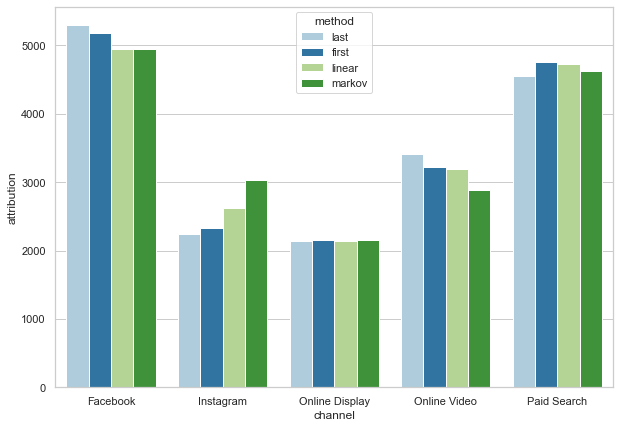

In [110]:
# 다른 모델에서 낮아보였던 Instagram의 기여도는 높아짐
sns.set_theme(style="whitegrid", palette="Paired")
g = sns.barplot(x=total_with_markov.channel, y=total_with_markov.attribution, hue = total_with_markov.method)
g.figure.set_size_inches(10, 7)